# Neural Network Project: #
**Reproducibility of fundings of the "DON’T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE" conference paper by Google:** <br>
https://openreview.net/pdf?id=B1Yy1BxCZ<br>
*Author: Igor Tryhub, 275235*

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dset
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

Defining an image classifier convolutional neural network model:

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Defining an image classifier ResNet model:

In [4]:
class BasickBlock(nn.Module):

    def __init__(self, n_in, n_out, stride=1):
        super(BasickBlock, self).__init__()
        self.connection = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(n_in, n_out, 3, stride, 1, bias=False)),
            ('norm1', nn.BatchNorm2d(n_out)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(n_out, n_out, 3, 1, 1, bias=False)),
            ('norm2', nn.BatchNorm2d(n_out)),
        ]))
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(n_in, n_out, 1, stride, bias=False),
            nn.BatchNorm2d(n_out),
        )
        self.stride = stride

    def forward(self, x):
        mapping = self.connection(x)
        if self.stride != 1:
            x = self.downsample(x)
        return self.relu(mapping + x)


class ResidualBlock(nn.Module):

    def __init__(self, n_in, n_out, n_block, stride=1):
        super(ResidualBlock, self).__init__()
        self.blocks = nn.Sequential()
        self.blocks.add_module('block0', BasickBlock(n_in, n_out, stride))
        for i in range(n_block - 1):
            self.blocks.add_module('block{}'.format(i + 1), BasickBlock(n_out, n_out))

    def forward(self, x):
        return self.blocks(x)


class ResNetCifar10(nn.Module):

    def __init__(self, n_block=3):
        super(ResNetCifar10, self).__init__()
        ch = [4, 8, 16]#ch = [16, 32, 64]
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, ch[0], 3, 1, 1, bias=False)),
            ('norm1', nn.BatchNorm2d(ch[0])),
            ('relu1', nn.ReLU(inplace=True)),
            ('resb1', ResidualBlock(ch[0], ch[0], n_block)),
            ('resb2', ResidualBlock(ch[0], ch[1], n_block, 2)),
            ('resb3', ResidualBlock(ch[1], ch[2], n_block, 2)),
            ('avgpl', nn.AvgPool2d(8)),
        ]))
        self.fc = nn.Linear(ch[2], 10)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, 0)

## Defining global meta-settings and initial values of parameters:

In [5]:
net = ResNetCifar10()
N = 50000
batch_size = 256
weight_decay=0.0005
momentum=0.9
lr=0.1
batch_scaling_coef = batch_size/lr #for future use
stat_every = 5000
epoch = 0
max_epochs = 180

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr, momentum, weight_decay)
history = {'train_losses': [], 'test_accuracies': []}
scenarios = {'learn_decay': 0, 'hybrid': 1, 'batch_increase': 2}
original_update_every = 60
update_every = 10
original_factor = 5
update_asif_original_factor = 4
update_factor = 1/(1.0/update_asif_original_factor)**(1.0/(original_update_every/update_every))
model_state_path = 'checkpoint.pth.tar'

A way to save state of parameters in case kernel dies during computation:

In [6]:
def save_checkpoint(state, filename=model_state_path):
    torch.save(state, filename)

Plotting function for the batch train loss and batch test accuracy plotting with respect to the batch number:

In [7]:
def plot_history(history):
    figsize(16, 4)
    
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='Training cross-entropy')
    legend()
        
    subplot(1,2,2)
    test_accuracies = np.array(history['test_accuracies'])
    plot(np.arange(test_accuracies.shape[0]), test_accuracies, label='Test set accuracy',color='g')
    legend()


Input CIFAR-10 dataset data transforming and splitting for a training and testing sets:

In [8]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Defining parameter update at 3 different convergence scenarios:

In [9]:
def param_update(epoch, scenario, optimizer, trainloader):
    if scenario == scenarios['learn_decay']:
        if epoch and not (epoch % update_every):
            optimizer.param_groups[0]['lr'] /= update_factor
            
    elif scenario == scenarios['hybrid']:
        if epoch and not (epoch % 50):
            trainloader.batch_size *= 4
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=trainloader.batch_size,
                                                shuffle=True, num_workers=1)
            if epoch >= 100:
                optimizer.param_groups[0]['lr'] /= 4
        
    elif scenario == scenarios['batch_increase']:
        if epoch and not (epoch % update_every):
            trainloader.batch_size = int(trainloader.batch_size * update_factor)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=trainloader.batch_size,
                                                shuffle=True, num_workers=1)
            
    return optimizer, trainloader

Training the neural network using Stochastic Gradient Descent (SGD) and measuring loss as cross-entropy:

In [10]:
def train(epoch, scenario, optimizer, trainloader):
    net.train()
        
    optimizer, trainloader = param_update(epoch, scenario, optimizer, trainloader)
    print("Epoch: {}      batch size: {}      learning rate: {}      weight decay: {}")\
        .format(epoch+1, trainloader.batch_size, optimizer.param_groups[0]['lr'], weight_decay)

    total = 0
    errors = 0
    train_loss = 0
    processed = 0
    for data in trainloader:
        processed += int(data[1].size()[0])
        inputs, labels = data # get the inputs            
        inputs, labels = Variable(inputs), Variable(labels) # wrap them in Variable
        optimizer.zero_grad() # zero the parameter gradients
        outputs = net.forward(inputs) # forward + backward + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        errors += (predicted != labels.data).sum()
        train_loss += loss.data[0]
        if (processed // stat_every):    # print loss statistics every `stat_every` processed elements
            print('\tLoss: %.3f' % (loss.data[0]))
            processed -= stat_every
            
    correct = total-errors
    train_accuracy = 100.0 * correct / total
    history['train_losses'].append(train_loss)
    print('\tAccuracy for training epoch: %.2f%%' % (train_accuracy))
    
    save_checkpoint({
        'epoch': epoch,
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'scenario' : scenario,
        'trainloader' : trainloader,
        'history' : history,
    })
    print("\tCheckpoint saved!")

Testing the network on the test data:

In [11]:
def test(epoch, testloader):
    net.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0
    
    for data in testloader:
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        if not((epoch+1)%5):
            c = (predicted == labels.data).squeeze()
            for i in range(int(data[1].size()[0])):
                label = labels[i]
                class_correct[label.data[0]] += c[i]
                class_total[label.data[0]] += 1
    
    test_accuracy = 100.0 * correct / total
    history['test_accuracies'].append(test_accuracy)
    print('\tAccuracy of the network on the 10000 test images: %.2f%%' % (test_accuracy))
    if not((epoch+1)%5):
        for i in range(10):
            print('\t\tFor %5s : %2d %%' % (
                classes[i], 100.0 * class_correct[i] / class_total[i]))

## Start of the program:

In [12]:
scenario = scenarios['learn_decay']
epochs_num = max_epochs

In [13]:
for e in range(max_epochs-epoch):
    if epoch==epochs_num:
        break
    train(epoch, scenario, optimizer, trainloader)
    test(epoch, testloader)
    epoch+=1

Epoch: 1      batch size: 256      learning rate: 0.1      weight decay: 0.0005
	Loss: 2.113
	Loss: 1.886
	Loss: 1.818
	Loss: 1.828
	Loss: 1.733
	Loss: 1.726
	Loss: 1.784
	Loss: 1.610
	Loss: 1.533
	Loss: 1.610
	Accuracy for training epoch: 32.36%
	Checkpoint saved!
	Accuracy of the network on the 10000 test images: 42.00%
Epoch: 2      batch size: 256      learning rate: 0.1      weight decay: 0.0005
	Loss: 1.551
	Loss: 1.522
	Loss: 1.522
	Loss: 1.550
	Loss: 1.410
	Loss: 1.394
	Loss: 1.308
	Loss: 1.449
	Loss: 1.397
	Loss: 1.368
	Accuracy for training epoch: 46.65%
	Checkpoint saved!
	Accuracy of the network on the 10000 test images: 50.00%
Epoch: 3      batch size: 256      learning rate: 0.1      weight decay: 0.0005
	Loss: 1.377
	Loss: 1.375
	Loss: 1.286
	Loss: 1.371
	Loss: 1.254
	Loss: 1.322
	Loss: 1.280
	Loss: 1.258
	Loss: 1.267
	Loss: 1.304
	Accuracy for training epoch: 53.46%
	Checkpoint saved!
	Accuracy of the network on the 10000 test images: 46.00%
Epoch: 4      batch size: 25

Process Process-45:
  File "/home/igort/anaconda3/envs/my_env/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/home/igort/anaconda3/envs/my_env/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/igort/anaconda3/envs/my_env/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/igort/anaconda3/envs/my_env/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
  File "/home/igort/anaconda3/envs/my_env/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


KeyboardInterrupt: 

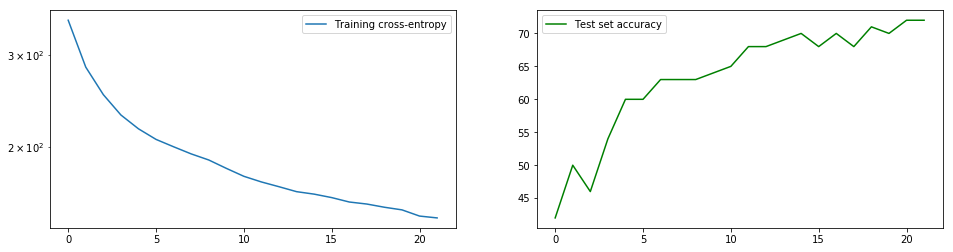

In [14]:
plot_history(history)

=========================================================================================================================
## CAUTION: the following cell loads last serialized parameters from memory and overwrites the current state: ##
=========================================================================================================================

In [ ]:
if os.path.isfile(model_state_path):
    checkpoint = torch.load(model_state_path)
    epoch = checkpoint['epoch'] + 1
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scenario = checkpoint['scenario']
    trainloader = checkpoint['trainloader']
    history = checkpoint['history']
    print("Checkpoint successfully loaded from '{}'!".format(model_state_path))